# Cleaning BioKG of benchmark-related entity pairs

In this notebook we take care of:

- Merging and disentangling the `BioKG graph` with the `benchmark datasets` that are included in it.
    - Benchmarks include: `dpi_fda`, `dpi_fda_exp`, `ddi_efficacy`, `ddi_mineral`, `ppi_phosphorylation`
- Storing the new disentangled data

**For this notebook to run, you require a local installation of the BioKG data.**

In [1]:
import os.path as osp
import os
import pandas as pd

## Load all links in BioKG are being combined in one single large (2m rows) .tsv file


In [2]:
biokg_links_path = "../data/biokg/biokg.links.tsv"

biokg_links = pd.read_csv(biokg_links_path,
                         sep='\t',
                         names=['left', 'property', 'right'])

print(f'There are {len(biokg_links,):,} edges in the loaded BioKG data.')

There are 2,074,346 edges in the loaded BioKG data.


In [3]:
biokg_links.head()

,left,property,right
0,C566487,DISEASE_PATHWAY_ASSOCIATION,hsa00071
1,C567839,DISEASE_PATHWAY_ASSOCIATION,map04810
2,C562476,DISEASE_PATHWAY_ASSOCIATION,hsa04512
3,C567032,DISEASE_PATHWAY_ASSOCIATION,map00750
4,C562710,DISEASE_PATHWAY_ASSOCIATION,map04930


Check out the **unique** properties in the links file...

In [4]:
biokg_links['property'].unique()

array(['DISEASE_PATHWAY_ASSOCIATION', 'PROTEIN_PATHWAY_ASSOCIATION',
       'DRUG_DISEASE_ASSOCIATION', 'RELATED_GENETIC_DISORDER', 'PPI',
       'DRUG_TARGET', 'DRUG_CARRIER', 'DRUG_ENZYME', 'DRUG_TRANSPORTER',
       'COMPLEX_IN_PATHWAY', 'DRUG_PATHWAY_ASSOCIATION',
       'PROTEIN_DISEASE_ASSOCIATION', 'DISEASE_GENETIC_DISORDER',
       'MEMBER_OF_COMPLEX', 'DDI', 'DPI', 'COMPLEX_TOP_LEVEL_PATHWAY'],
      dtype=object)

As we can observe, the relations in the benchmarks are `normalised` before being merged in the graph.
This implies that we should merge on right,left column ignoring the property name + order.

## Load & Merge all benchmark datasets

In [5]:
benchmark_path ='../data/benchmarks/'
benchmark_files = ['dpi_fda.tsv',
                   'dep_fda_exp.tsv',
                   'ddi_efficacy.tsv',
                   'ddi_minerals.tsv',
                   'phosphorylation.tsv']

def load_benchmark_file(path):
    return pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 2], names=['left', 'property', 'right'])

all_benchmarks = pd.concat([load_benchmark_file(osp.join(benchmark_path, file)) for file in benchmark_files])
print(f'There are {len(all_benchmarks):,} pairs in the merged benchmarks.')
all_benchmarks.head()

There are 1,160,376 pairs in the merged benchmarks.


,left,property,right
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637
3,DB01069,DPI,P18825
4,DB01186,DPI,P08684


Before merging we need to prepare and ignore the order between left and right columns.

To do that:
- We create a new column called `combined`, containing the head and tail entities in a pair, and sort them lexicographically.
- We merge the benchmark and KG dataframes on the `combined` column.
- Then by picking out the `right_only` results we know we have the BioKG graph without the benchmarks.

In [6]:
def combine_and_sort_entities(df):
    """Given a dataset containing pairs in the columns `left` and `right`,
    creates a new column called `combined` containing the pairs as a
    list (in string format) with the pairs sorted in lexicographical order."""
    df['combined'] = df.apply(lambda x: str(sorted([x['left'], x['right']])), axis=1)
    return df

combine_and_sort_entities(all_benchmarks)
all_benchmarks.head()

,left,property,right,combined
0,DB01079,DPI,Q13639,"['DB01079', 'Q13639']"
1,DB00114,DPI,P20711,"['DB00114', 'P20711']"
2,DB01158,DPI,P13637,"['DB01158', 'P13637']"
3,DB01069,DPI,P18825,"['DB01069', 'P18825']"
4,DB01186,DPI,P08684,"['DB01186', 'P08684']"


In [7]:
combine_and_sort_entities(biokg_links)
biokg_links.head()

,left,property,right,combined
0,C566487,DISEASE_PATHWAY_ASSOCIATION,hsa00071,"['C566487', 'hsa00071']"
1,C567839,DISEASE_PATHWAY_ASSOCIATION,map04810,"['C567839', 'map04810']"
2,C562476,DISEASE_PATHWAY_ASSOCIATION,hsa04512,"['C562476', 'hsa04512']"
3,C567032,DISEASE_PATHWAY_ASSOCIATION,map00750,"['C567032', 'map00750']"
4,C562710,DISEASE_PATHWAY_ASSOCIATION,map04930,"['C562710', 'map04930']"


## Merging the benchmarks and BioKG on the `combined` column

In [8]:
merged = pd.merge(all_benchmarks, biokg_links, how='right', on=["combined"], indicator=True)

In [9]:
merged.head()

,left_x,property_x,right_x,combined,left_y,property_y,right_y,_merge
0,NaN,NaN,NaN,"['C566487', 'hsa00071']",C566487,DISEASE_PATHWAY_ASSOCIATION,hsa00071,right_only
1,NaN,NaN,NaN,"['C567839', 'map04810']",C567839,DISEASE_PATHWAY_ASSOCIATION,map04810,right_only
2,NaN,NaN,NaN,"['C562476', 'hsa04512']",C562476,DISEASE_PATHWAY_ASSOCIATION,hsa04512,right_only
3,NaN,NaN,NaN,"['C567032', 'map00750']",C567032,DISEASE_PATHWAY_ASSOCIATION,map00750,right_only
4,NaN,NaN,NaN,"['C562710', 'map04930']",C562710,DISEASE_PATHWAY_ASSOCIATION,map04930,right_only


The counts of the following values in the `_merge` column are useful:
- `right_only`: the number of pairs in BioKG that are not in the benchmarks.
- `both`: the number of pairs in the benchmark that also appear in BioKG. **Note**: there might be duplicates in this part:
  for example, if a pair (A, B) is in the benchmark, there might be triples in BioKG of the form (A, x, B), (A, y, B), (B, z, A),
  all of which would count towards shared pairs in `both`.

In [10]:
merged[['_merge']].value_counts()

_merge    
right_only    1852262
both           226266
left_only           0
dtype: int64

What do these shared pairs look like?

In [11]:
merged[merged['_merge'] == 'both'].head()

,left_x,property_x,right_x,combined,left_y,property_y,right_y,_merge
328244,P28482,phosphorylates,O75582,"['O75582', 'P28482']",O75582,PPI,P28482,both
328245,P28482,phosphorylates,O75582,"['O75582', 'P28482']",O75582,PPI,P28482,both
328297,P06493,phosphorylates,P02545,"['P02545', 'P06493']",P02545,PPI,P06493,both
328298,P06493,phosphorylates,P02545,"['P02545', 'P06493']",P02545,PPI,P06493,both
328299,P06493,phosphorylates,P02545,"['P02545', 'P06493']",P02545,PPI,P06493,both


## Removing the benchmarks from BioKG

In [12]:
biokg_without_benchmarks = merged[merged['_merge'] == 'right_only'][['left_y', 'property_y', 'right_y']]
biokg_without_benchmarks.rename(columns={'left_y': 'left', 'property_y': 'property', 'right_y': 'right'}, inplace=True)
biokg_without_benchmarks.head()

,left,property,right
0,C566487,DISEASE_PATHWAY_ASSOCIATION,hsa00071
1,C567839,DISEASE_PATHWAY_ASSOCIATION,map04810
2,C562476,DISEASE_PATHWAY_ASSOCIATION,hsa04512
3,C567032,DISEASE_PATHWAY_ASSOCIATION,map00750
4,C562710,DISEASE_PATHWAY_ASSOCIATION,map04930


In [13]:
print(f'After removing the benchmarks, there are {len(biokg_without_benchmarks):,} edges in the BioKG graph, down from {len(biokg_links):,}.')
print(f'This is a reduction of {100*(len(biokg_links)-len(biokg_without_benchmarks))/len(biokg_links):.2f}%.')
# Fun fact: the previous line of code was autocompleted by Github copilot, i.e. OpenAI Codex.

After removing the benchmarks, there are 1,852,262 edges in the BioKG graph, down from 2,074,346.
This is a reduction of 10.71%.


At this point we need to make sure: **are all entities in the benchmarks still present in BioKG after this removal?**.
This will guarantee that when training embeddings with BioKG, we can make predictions for all entities in the benchmark.
We also call this the *transductive property*.

In [14]:
def get_entity_set(df):
    return set(df['left'].unique()) | set(df['right'].unique())

unique_benchmark_entities = get_entity_set(all_benchmarks)
original_biokg_entities = get_entity_set(biokg_links)
biokg_entities = get_entity_set(biokg_without_benchmarks)
entities_not_in_biokg = unique_benchmark_entities.difference(biokg_entities)

print(f'The benchmarks have {len(unique_benchmark_entities):,} entities')
print(f'The original version of BioKG has {len(original_biokg_entities):,} entities')
print(f'The clean (no benchmarks) version of BioKG has {len(biokg_entities):,} entities')
print(f'There are {len(entities_not_in_biokg):,} entities in the benchmarks missing from the reduced version of BioKG.')

The benchmarks have 59,651 entities
The original version of BioKG has 106,337 entities
The clean (no benchmarks) version of BioKG has 106,047 entities
There are 13,419 entities in the benchmarks missing from the reduced version of BioKG.


This means that there are some entities in the benchmarks for which we can't make any predictions
if we train a method like ComplEx with the clean version of BioKG.

### Missing entities in the original BioKG

It turns out that even without removing the benchmarks from BioKG, there are still some entities
in the benchmarks missing from it:

In [15]:
missing_in_original_biokg = unique_benchmark_entities.difference(original_biokg_entities)

print(f'{len(missing_in_original_biokg):,} benchmarks entities are not in BioKG. For example:')
for i, e in enumerate(missing_in_original_biokg):
    print(f'\t{e}')
    if i == 5: break

13,129 benchmarks entities are not in BioKG. For example:
	Q9DAM3
	A7YWH3
	Q9HAI6
	Q9VG82
	Q5F415
	Q6DBY2


All these could be kept to create an **inductive** version of the benchmarks.

### An interesting observation on very similar entities

One of the entities present in the benchmarks is `Q5ZL35`. It turns out
that this entity has the same pairs in the benchmarks as `Q9NWB6`:

In [16]:
q5zl35_benchmarks = all_benchmarks[all_benchmarks['right'] == 'Q5ZL35'].sort_values(by='left', ignore_index=True)
q9nwb6_benchmarks = all_benchmarks[all_benchmarks['right'] == 'Q9NWB6'].sort_values(by='left', ignore_index=True)
q5zl35_benchmarks[['left', 'property']].equals(q9nwb6_benchmarks[['left', 'property']])

True

We could be tempted to say that these two entities are in fact the same,
and the data contains duplicates, but this is not the case.

They correspond to Arginine and glutamate-rich protein 1, but one of them
is present in Chicken and the other in Humans. Even though they have the same
pairs, their protein sequences are very different. These are their entries
in Uniprot:

- [Q5ZL35](https://www.uniprot.org/uniprotkb/Q5ZL35/entry)
- [Q9NWB6](https://www.uniprot.org/uniprotkb/Q9NWB6/entry)

This raises an interesting point about embedding these entities with
knowledge graph embeddings: a method like ComplEx (based on the graph structure alone)
wouldn't be able to distinguish between them, while incorporating their protein sequences could solve this.

## Statistics of properties before and after removal

We start by computing counts of relation types in the original BioKG, and in the clean version.

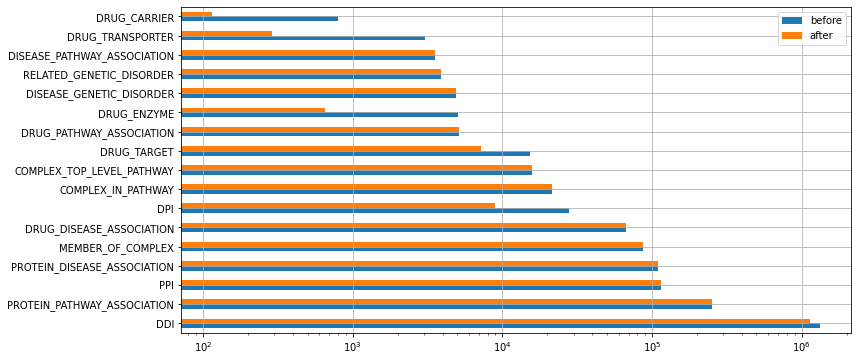

In [17]:
def get_property_counts(df):
    return df['property'].value_counts()

# Get counts for biokg_links and biokg_without_benchmarks
biokg_links_property_counts = get_property_counts(biokg_links)
biokg_without_benchmarks_property_counts = get_property_counts(biokg_without_benchmarks)
# Merge into one dataframe
before_and_after_counts = pd.concat([biokg_links_property_counts, biokg_without_benchmarks_property_counts], axis=1)
before_and_after_counts.columns = ['before', 'after']
before_and_after_counts.plot.barh(logx=True, grid=True, figsize=(12, 6));

We can see that the largest drop in the number of edges corresponds to the `DRUG_CARRIER` relation.

Next we look at the entity counts before and after removal. We do this by visualizing a histogram of
entity degrees.

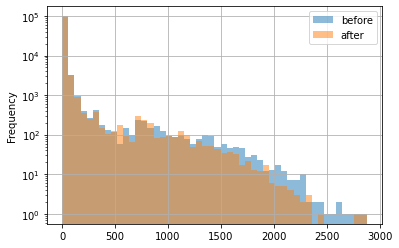

In [18]:
def plot_degree_histogram(df, bins=50, label=None):
    df_head_tails = pd.concat([df['left'], df['right']], axis=0)
    df_head_tails.value_counts().plot(kind='hist', logy=True, bins=bins, grid=True, alpha=0.5, label=label, legend=True)

plot_degree_histogram(biokg_links, label='before')
plot_degree_histogram(biokg_without_benchmarks, label='after')

## Storing the cleaned version of BioKG

We start with the clean version of BioKG, which is the one we will use for training, validation, and testing of the link prediction model.

In [19]:
output_dir = osp.join('..', 'data', 'biokgb')
kg_output_dir = osp.join(output_dir, 'graph')
if not osp.exists(kg_output_dir):
    os.makedirs(kg_output_dir)

biokg_without_benchmarks.to_csv(osp.join(kg_output_dir, 'biokg.links.csv'), sep='\t', index=False, header=False)

## Storing the *transductive* version of the benchmarks

Since we found out that after removing benchmarks pairs from BioKG, some entities were removed
entirely from the graph, we will store versions of the benchmarks that only contain entities
in the new version of BioKG.

In [20]:
benchmarks_output_dir = osp.join(output_dir, 'benchmarks')
if not osp.exists(benchmarks_output_dir):
    os.makedirs(benchmarks_output_dir)

print(f'{"Benchmark":<20}{"Before":>10}{"After":>10}{"Relative":>10}')
print('-' * 50)

for file in benchmark_files:
    benchmark = load_benchmark_file(osp.join(benchmark_path, file))

    transductive_benchmark = benchmark[benchmark['left'].isin(biokg_entities) & benchmark['right'].isin(biokg_entities)]
    transductive_benchmark.to_csv(osp.join(benchmarks_output_dir, file), sep='\t', index=False, header=False)

    percentage_kept = len(transductive_benchmark) / len(benchmark)
    print(f'{file:<20}{len(benchmark):>10,}{len(transductive_benchmark):>10,}{percentage_kept:>10.1%}')

Benchmark               Before     After  Relative
--------------------------------------------------
dpi_fda.tsv             19,161    18,678     97.5%
dep_fda_exp.tsv        929,077   800,961     86.2%
ddi_efficacy.tsv       130,145   125,509     96.4%
ddi_minerals.tsv        55,890    50,304     90.0%
phosphorylation.tsv     26,103    24,549     94.0%
